In [391]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_market_calendars as mcal
import datetime as dt
import scipy as sp

import pymc3 as pm
from theano import tensor as tt
from theano import shared
import arviz as az
az.style.use("arviz-darkgrid")

import os
import sys

from util import *

from jupyterthemes import jtplot
jtplot.style(theme="monokai")

# Data

In [2]:
os.listdir()

['.ipynb_checkpoints', 'LNG.csv', 'Stoch Vol Models.ipynb', '^DJI.csv']

In [3]:
dji = pd.read_csv("^DJI.csv", index_col="Date", parse_dates=True)["Adj Close"]
dji.head()

Date
2017-01-03    19881.759766
2017-01-04    19942.160156
2017-01-05    19899.289063
2017-01-06    19963.800781
2017-01-09    19887.380859
Name: Adj Close, dtype: float64

Text(0.5, 1.0, 'DJI Time Series')

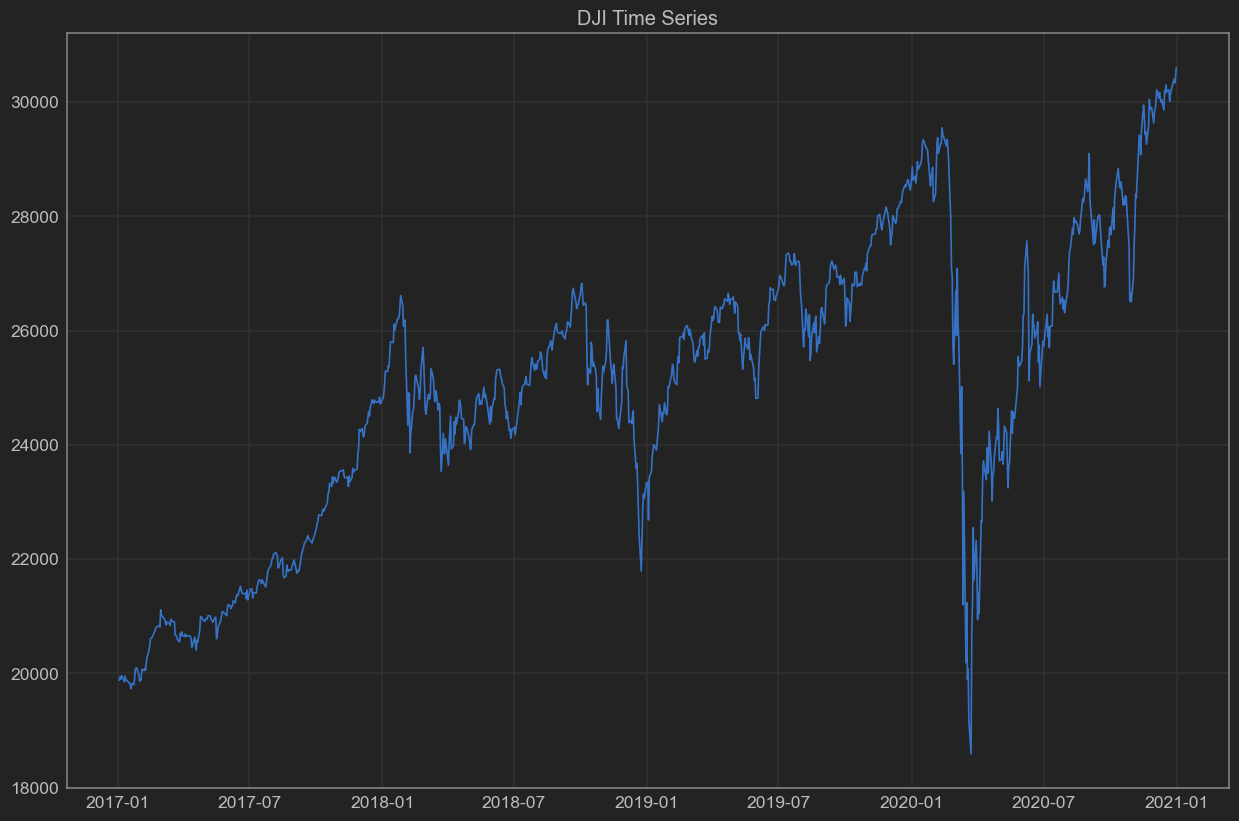

In [4]:
plt.figure(figsize=(15,10))
plt.plot(dji.index, dji)
plt.title("DJI Time Series")

In [5]:
dji = dji.pct_change()
dji = dji.dropna()
dji.head()

Date
2017-01-04    0.003038
2017-01-05   -0.002150
2017-01-06    0.003242
2017-01-09   -0.003828
2017-01-10   -0.001602
Name: Adj Close, dtype: float64

Text(0.5, 1.0, 'Histogram of DJI daily returns')

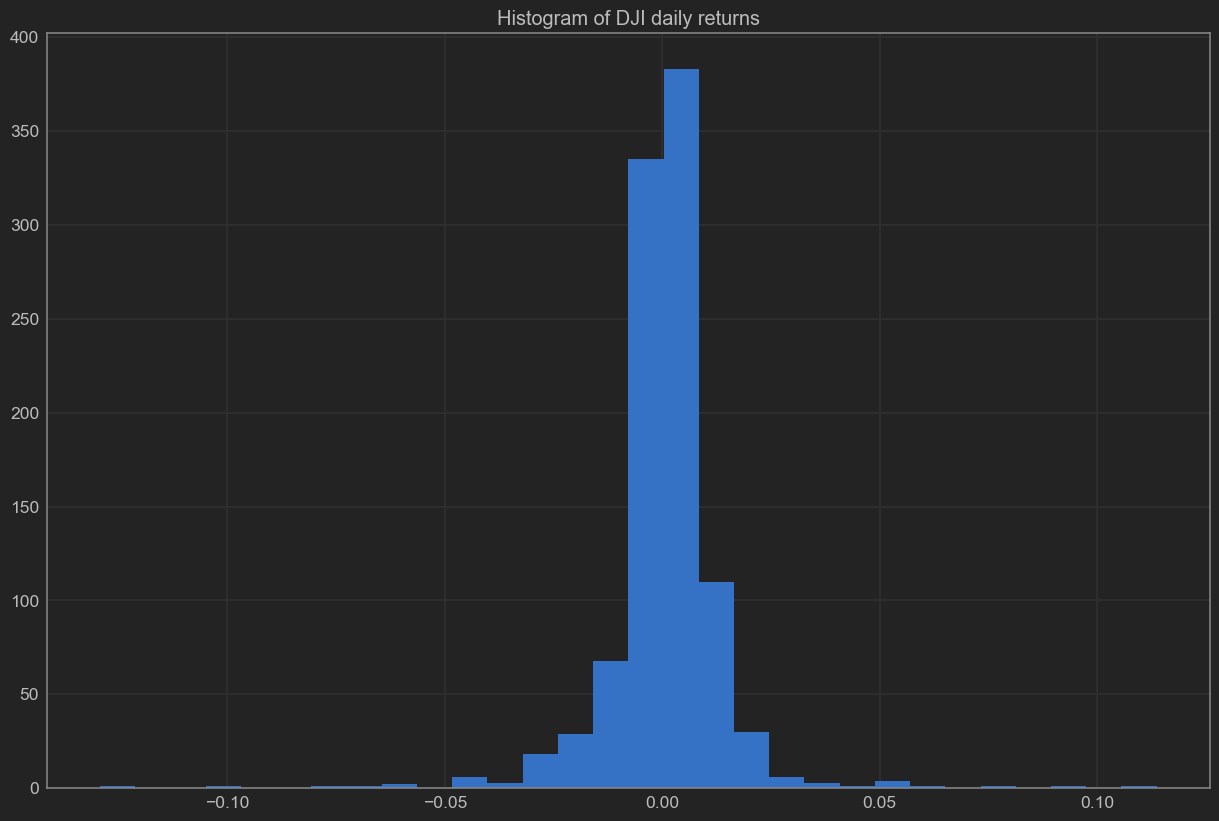

In [6]:
plt.figure(figsize=(15,10))
plt.hist(dji, bins=30)
plt.title("Histogram of DJI daily returns")

Text(0.5, 1.0, 'DJI daily returns time series')

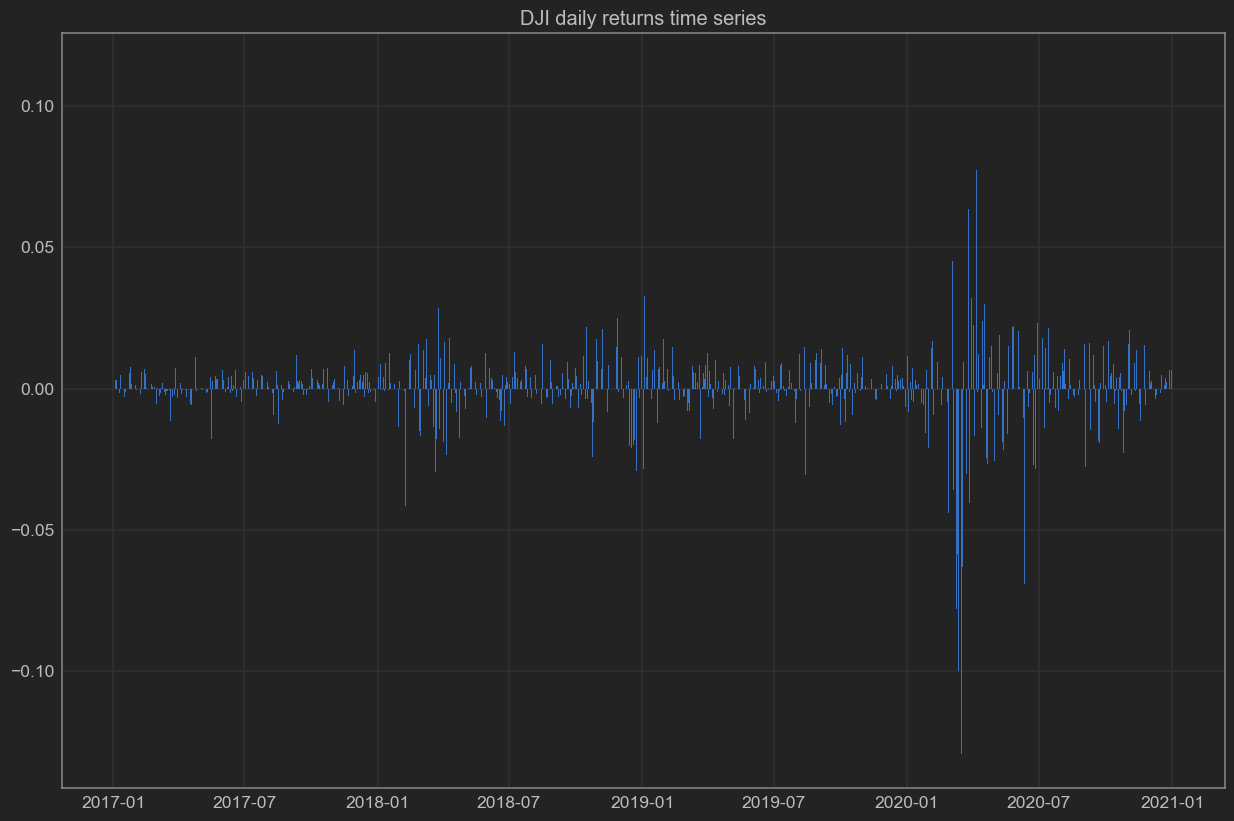

In [7]:
plt.figure(figsize=(15,10))
plt.bar(dji.index, dji)
plt.title("DJI daily returns time series")

# Model 1: Simple

Stochastic volatility model, described here: https://arxiv.org/abs/1507.08050#:~:text=Probabilistic%20programming%20(PP)%20allows%20flexible,statisticians%20use%20to%20describe%20models.

Model:
\begin{align*}
\sigma &\sim exp(0.5) \\
\nu &\sim exp(0.1) \\
s_i &\sim \mathcal{N}(s_{i-1}, \sigma^{-2}) \\
\log (y_i) &\sim t(\nu, 0, exp(-2s_i))
\end{align*}

In [14]:
# Define the model
with pm.Model() as dji_model:
    data_container = pm.Data('data', dji)
    nu = pm.Exponential('nu', 1./10, testval=.1)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)
    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(dji))
    volatility_process = pm.Deterministic('volatility_process', tt.exp(-2*s))
    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=data_container)

In [15]:
# Now sample the posterior
nsamps=2000
with dji_model:
    trace = pm.sample(nsamps)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:25<00:00, 116.30draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not e

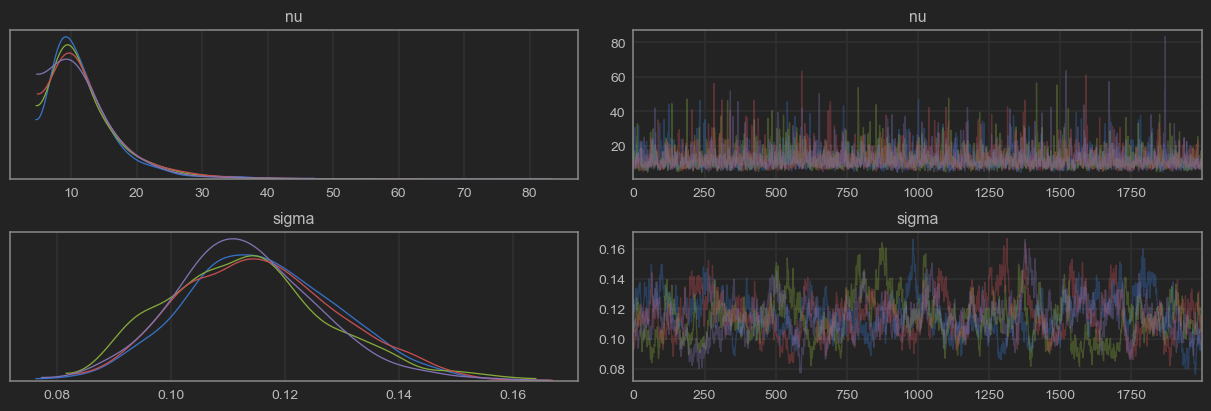

In [16]:
# Simple traceplot
az.plot_trace(trace, var_names=['nu', 'sigma']);

Text(0.5, 1.0, 'Volatility Process s_t')

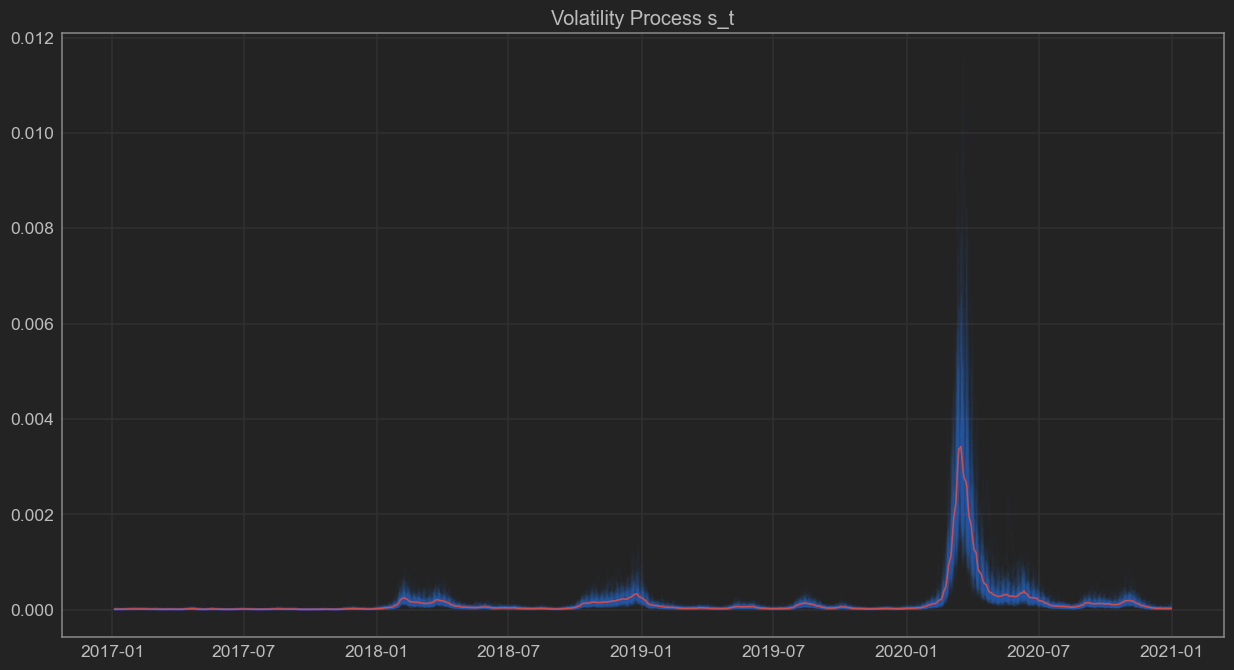

In [297]:
# Let's look at some samples of the volatility process
plt.figure(figsize=(15,8))
vol_data = trace["volatility_process"]
mean_vol = vol_data.mean(axis=0)
plt.plot(dji.index, vol_data[::30].T, 'b', alpha=.03);
plt.plot(dji.index, mean_vol, 'r');
plt.title("Volatility Process s_t")

## Posterior Forecasting

In [357]:
# Now draw samples
with dji_model:
    pm.set_data({'data' : np.ones(len(new_mkt_days))})
    ppc_samples = pm.sample_ppc(trace, var_names=["r", "s", "sigma", "volatility_process", "nu"])

<ipython-input-357-1d398ddcc052>:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  ppc_samples = pm.sample_ppc(trace, var_names=["r", "s", "sigma", "volatility_process", "nu"])
100%|██████████| 8000/8000 [01:01<00:00, 130.30it/s]


Text(0.5, 1.0, 'Credible Intervals for the Volatility Process')

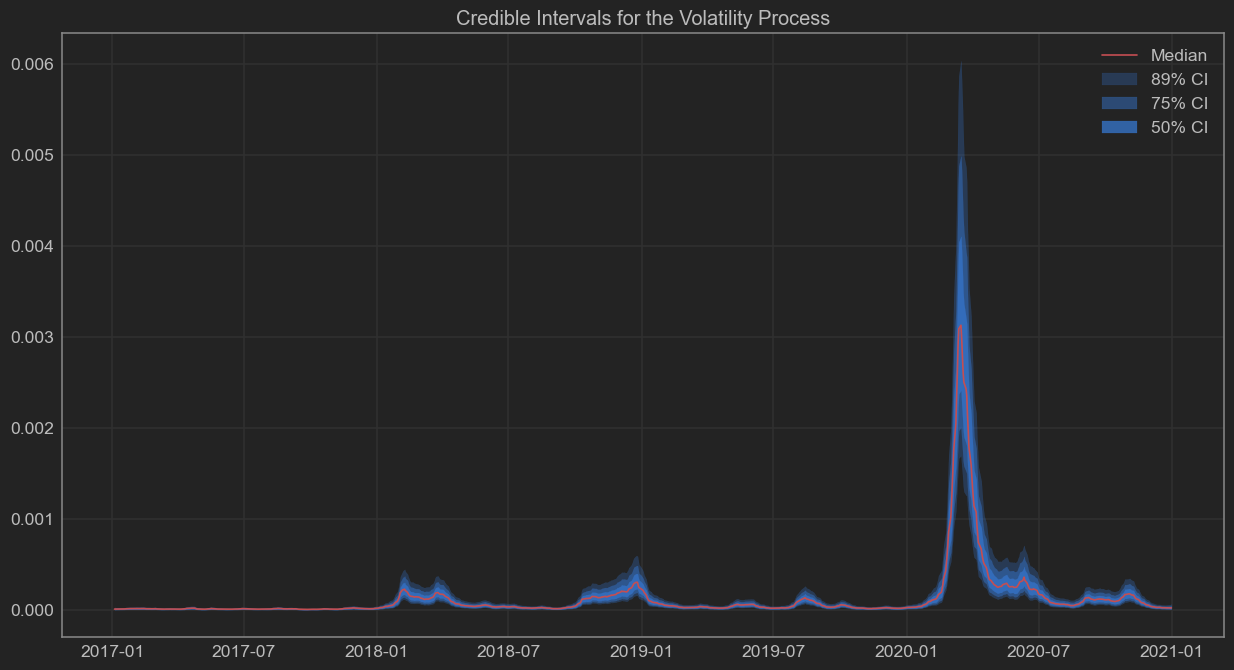

In [392]:
vol_bands = compute_bands(ppc_samples["volatility_process"])
plt.figure(figsize=(15,8))
plot_training_vol_bands(dji, vol_bands)
plt.title("Credible Intervals for the Volatility Process")

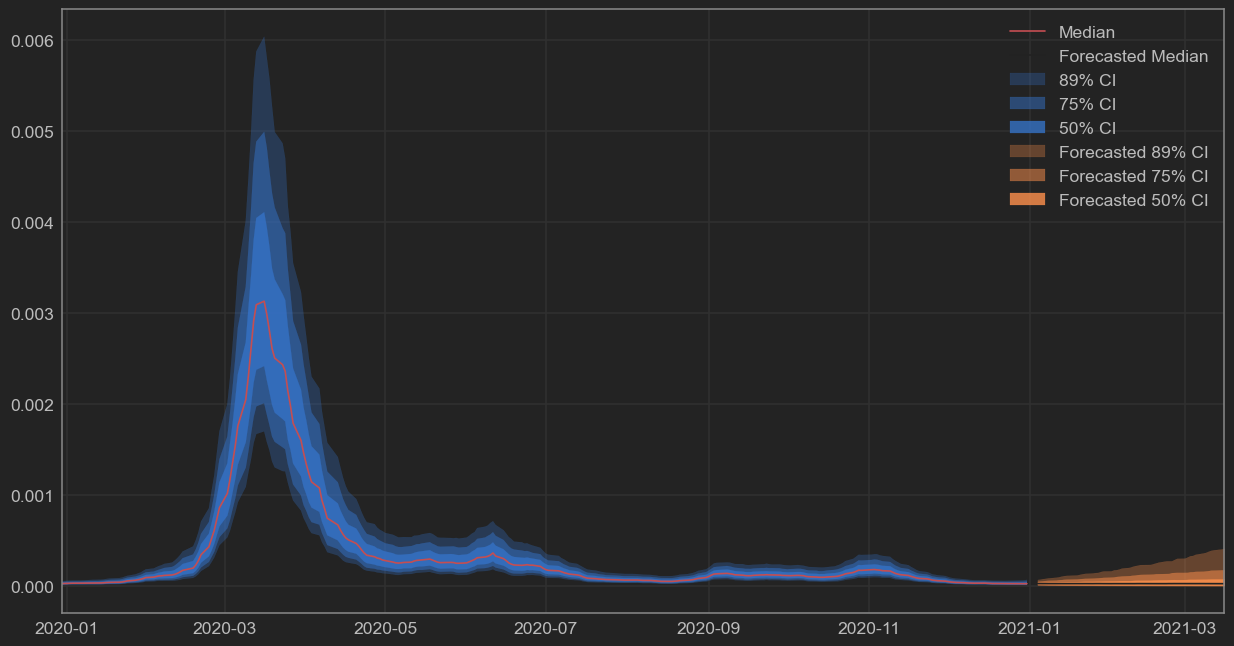

In [411]:
# Now compute the forward looking forecast
new_dates, new_vol, new_rets = calc_forecast(dji, ppc_samples, 50)
new_vol_bands =  compute_bands(new_vol)
plt.figure(figsize=(15,8))
plot_forecast_vol_bands(dji, vol_bands, new_dates, new_vol_bands, prev_dates=255)

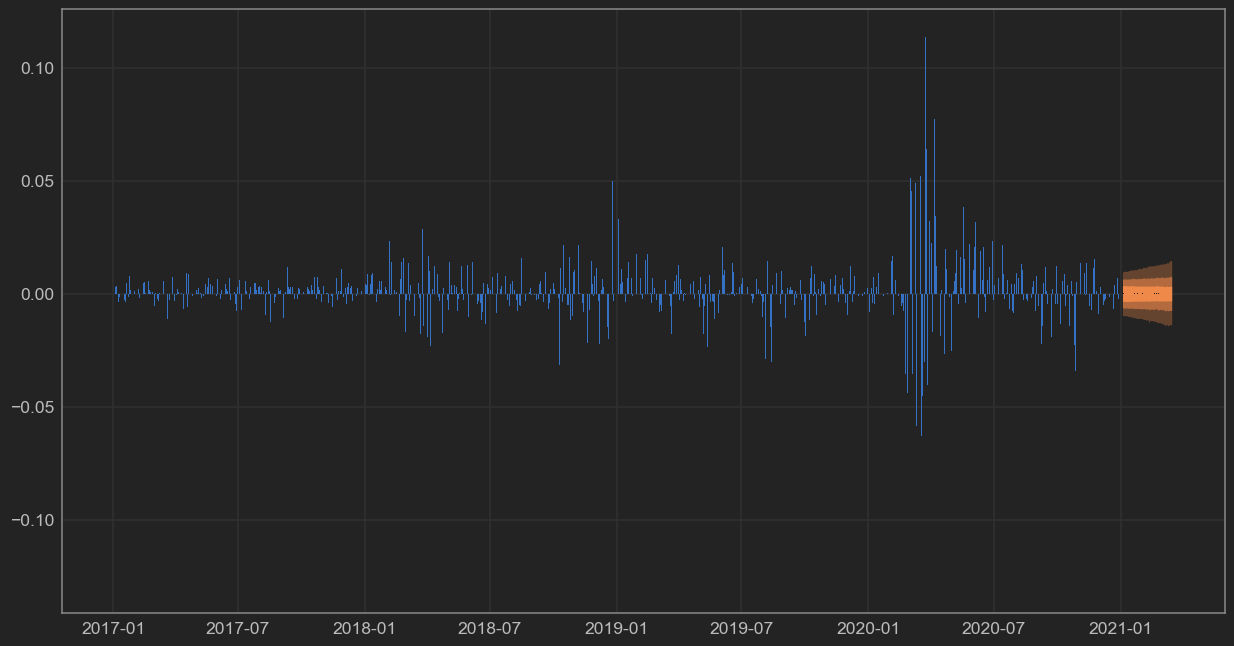

In [417]:
# Let's look at the historic returns vs forecasted returns
plt.figure(figsize=(15,8))
new_ret_bands = compute_bands(new_rets)
plot_ret_forecast(dji, new_dates, new_ret_bands)

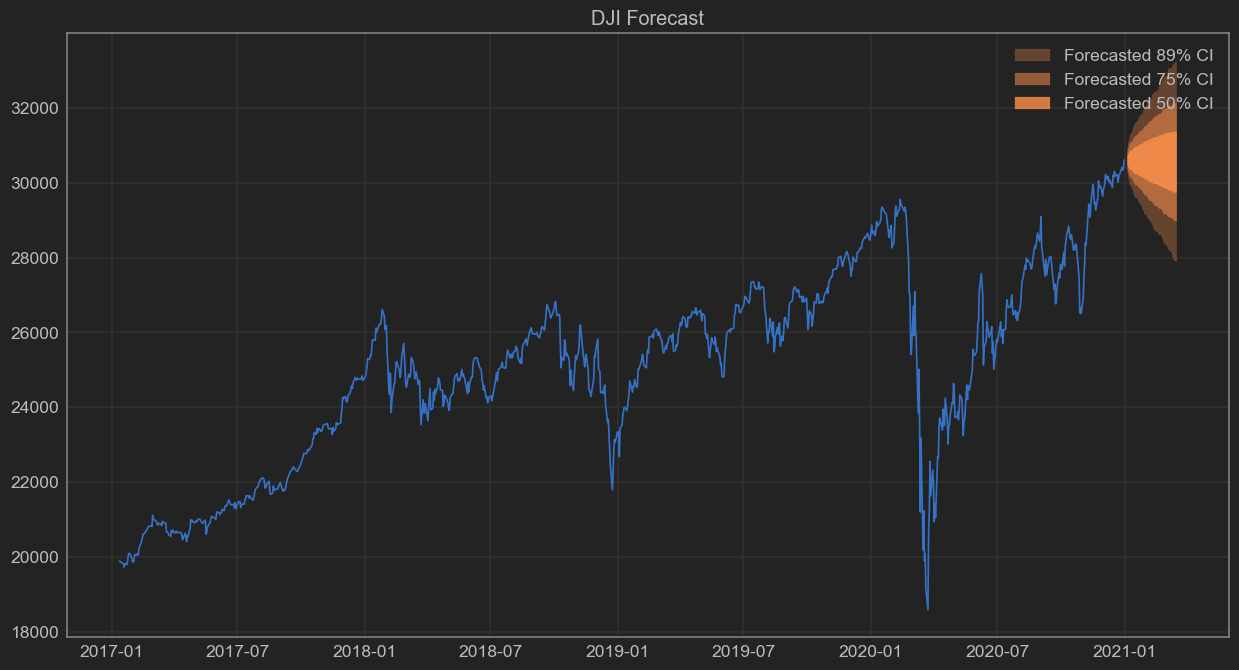

In [454]:
# Now let's look at this in terms of the raw DJI index
dji_raw = pd.read_csv("^DJI.csv", index_col="Date", parse_dates=True)["Adj Close"]
forecasted_price = dji_raw[-1]*((1.0 + new_rets).cumprod(axis=1))
forecasted_price_bands = compute_bands(forecasted_price)
plt.figure(figsize=(15,8))
plot_price_forecast(dji_raw, new_dates, forecasted_price_bands, prev_dates=1000)
plt.title("DJI Forecast")
plt.savefig("dji_forecast", dpi=250)

Text(0.5, 1.0, 'DJI Forecast')

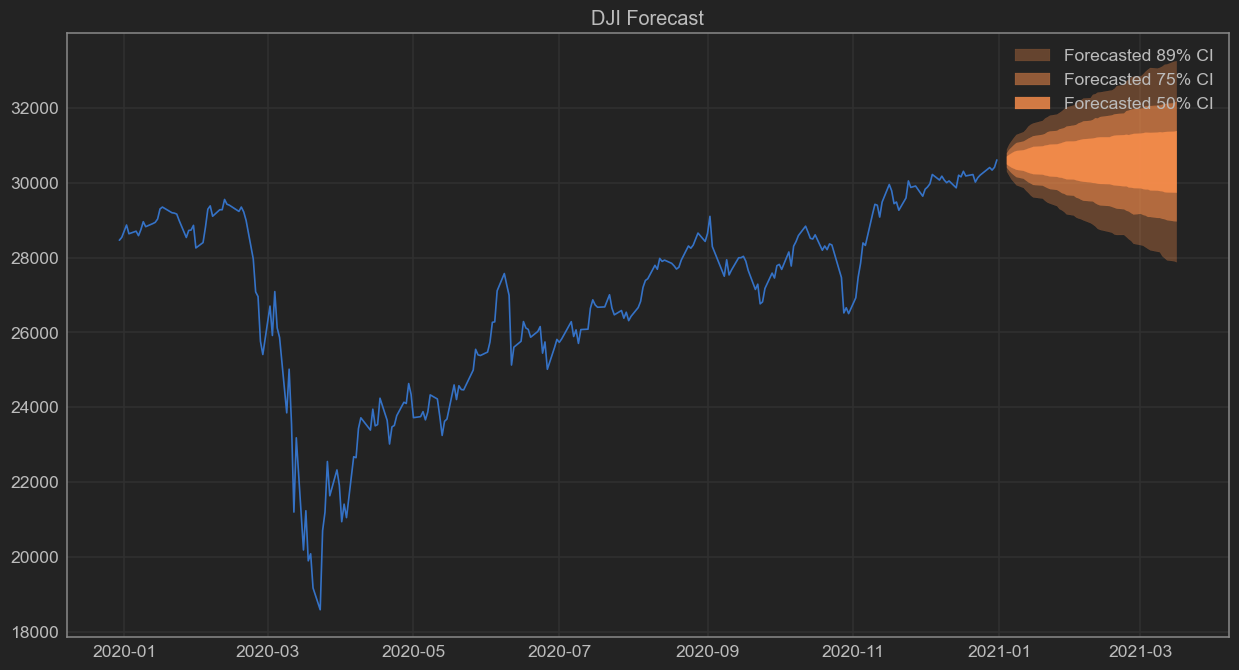

In [452]:
plt.figure(figsize=(15,8))
plot_price_forecast(dji_raw, new_dates, forecasted_price_bands, prev_dates=255)
plt.title("DJI Forecast")

Text(0.5, 1.0, 'DJI Forecast')

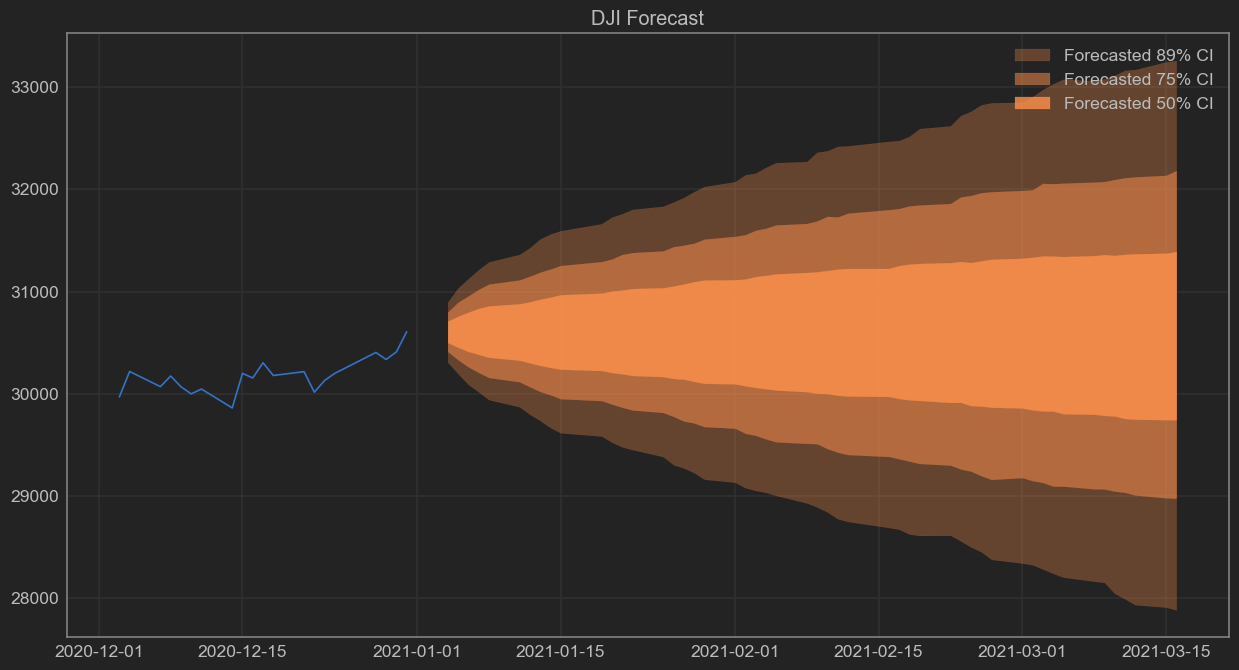

In [453]:
plt.figure(figsize=(15,8))
plot_price_forecast(dji_raw, new_dates, forecasted_price_bands, prev_dates=20)
plt.title("DJI Forecast")

# Re-do of the above, to allow for a posterior predictive check

In [461]:
first_test_day = "2020-06-01"
dji = pd.read_csv("^DJI.csv", index_col="Date", parse_dates=True)["Adj Close"]
train = dji.loc[:first_test_day]
test = dji.loc[first_test_day:]

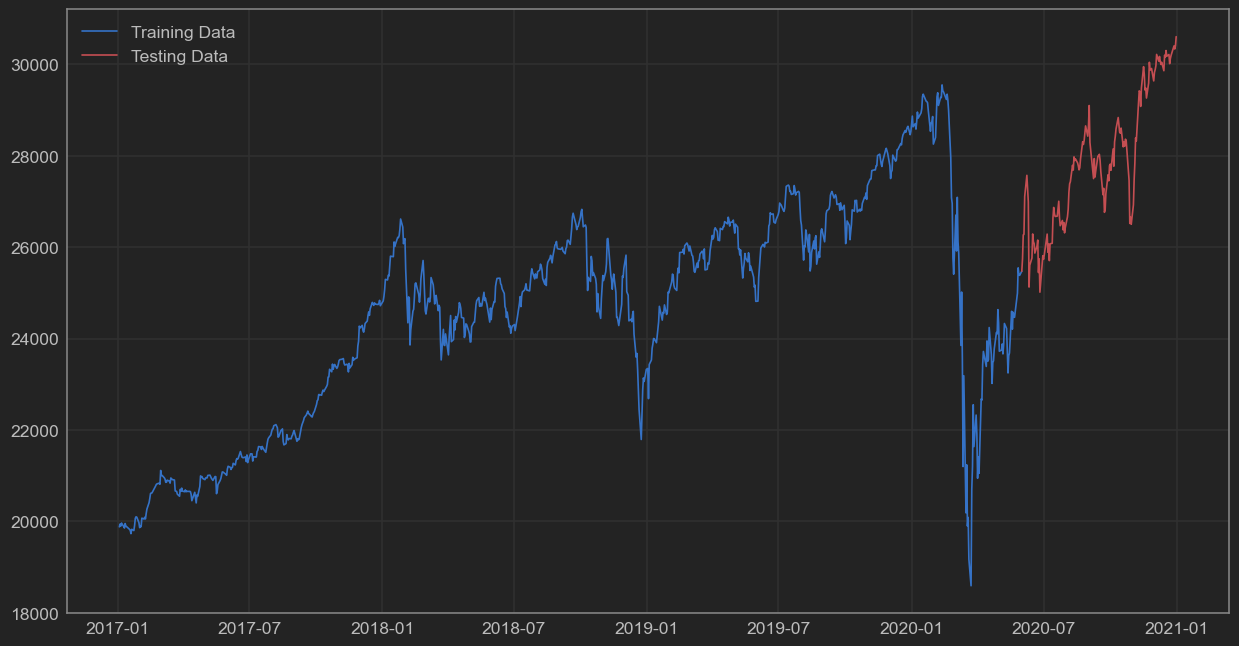

In [462]:
plt.figure(figsize=(15,8))
plt.plot(train.index, train, c="b", label="Training Data")
plt.plot(test.index, test, c="r", label="Testing Data")
plt.legend()

In [464]:
test = test.pct_change()
train = train.pct_change()
test = test.dropna()
train = train.dropna()

In [466]:
# Define the model
with pm.Model() as stoch_vol:
    data_container = pm.Data('data', train)
    nu = pm.Exponential('nu', 1./10, testval=.1)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)
    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(train))
    volatility_process = pm.Deterministic('volatility_process', tt.exp(-2*s))
    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=data_container)

In [467]:
# Now sample the posterior
nsamps=10000
with dji_model:
    trace = pm.sample(nsamps)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains, 0 divergences:   0%|          | 0/42000 [00:17<?, ?draws/s]


RuntimeError: Chain 0 failed.

In [ ]:
# Simple traceplot
az.plot_trace(trace, var_names=['nu', 'sigma']);

# Code graveyard

In [ ]:
# Make a new series with appended missing vals to be passed in
empty_vals = np.empty(fdays)
empty_vals[:] = np.nan
new_idx = dji.index.union(new_mkt_days.index)
data = pd.Series(index=new_idx, data=np.concatenate((dji.values, empty_vals)))
data = pd.DataFrame(data={"rets":data})

In [342]:
def compute_bands(vals, levels=[5, 25, 75, 95]):
    def scoreatpercentile(vals, p):
        return [sp.stats.scoreatpercentile(temp,p) for temp in vals.T]
    perc = {p:scoreatpercentile(vals,p) for p in levels}
    return perc

In [ ]:
def plot_vol_cred()
    '''

In [350]:
new_dates, new_vol_proc, new_rets = calc_forecast(dji, ppc_samples, 100)
vol_bands = compute_bands(ppc_samples["volatility_process"])

In [346]:
result[1].shape

(1000, 100)

In [349]:
result

(DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
                '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
                '2021-01-14', '2021-01-15', '2021-01-19', '2021-01-20',
                '2021-01-21', '2021-01-22', '2021-01-25', '2021-01-26',
                '2021-01-27', '2021-01-28', '2021-01-29', '2021-02-01',
                '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
                '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
                '2021-02-12', '2021-02-16', '2021-02-17', '2021-02-18',
                '2021-02-19', '2021-02-22', '2021-02-23', '2021-02-24',
                '2021-02-25', '2021-02-26', '2021-03-01', '2021-03-02',
                '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-08',
                '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
                '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
                '2021-03-19', '2021-03-22', '2021-03-23', '2021-

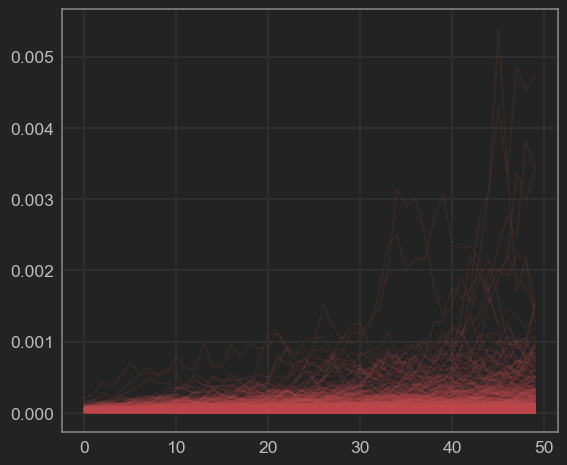

In [304]:
plt.plot(new_vol_proc.T, c="r", alpha=0.1);

In [277]:
#new_data_samp = pd.concat([dji, pd.Series(index=new_mkt_days, data=new_rets[0,:])])

<BarContainer object of 1056 artists>

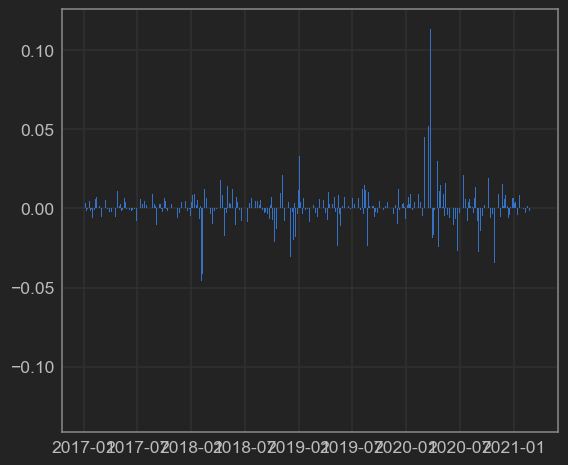

In [278]:
plt.bar(new_data_samp.index, new_data_samp)

(950.0, 1200.0)

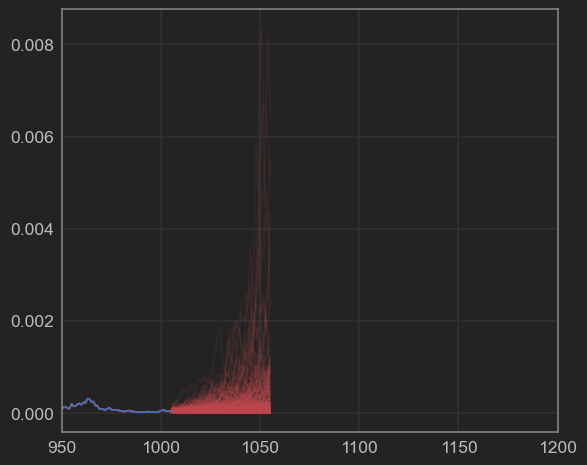

In [295]:
for j in range(1000):
    plt.plot(np.exp(-2*np.append(ppc_samples["s"][0,:], new_s_t[j,:])), c="r", alpha=0.1)
plt.plot(np.exp(-2*ppc_samples["s"][0,:]), c="b")
plt.xlim(950, 1200)

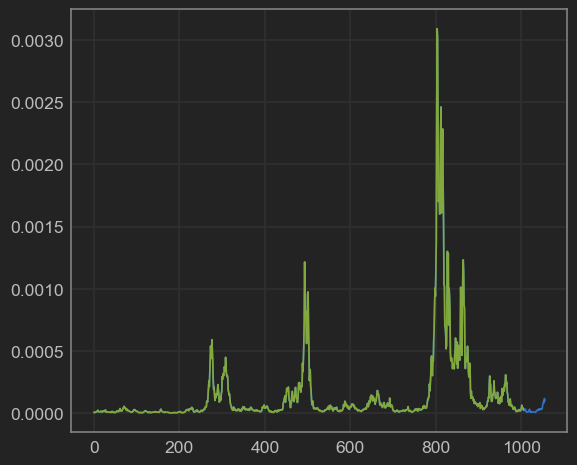

In [285]:
plt.plot(np.exp(-2*np.append(ppc_samples["s"][0,:], new_s_t[8,:])))
plt.plot(np.exp(-2*ppc_samples["s"][0,:]))

In [37]:
def draw_new_vol(data, fdays, init_s, init_t):
    '''
    Draws forward-looking samples of the volatility process.
    
    Parameters
    --------------------------------------------------------
    data: series of returns data with datetime index
    fdays: number of forward-looking days to predict
    init_s: value of s_t at last observed data point
    init_t: datetime of the last observed data point
    '''
    last_time
    
    sigmas = 

['nu_log__', 'sigma_log__', 's', 'nu', 'sigma', 'volatility_process']

In [73]:
fdays = 100
sigma = 2
np.random.normal(scale=(1./sigma), size=fdays).cumsum()

array([-4.16143517e-01, -3.00283789e-01,  2.30854045e-01, -1.04967227e-01,
       -3.00844548e-01, -5.23519702e-01, -6.13861828e-02,  1.16583162e-02,
        5.43612912e-01,  2.58725267e-01,  1.11884216e-01, -5.69142898e-02,
        5.98902510e-01,  1.12369274e+00,  1.68714706e+00,  1.62500892e+00,
        1.03613206e+00,  8.32262864e-01,  1.00937746e+00,  3.67239497e-01,
        7.46955177e-01,  5.64516332e-01,  5.88700099e-01,  6.60848249e-01,
        1.59830872e-01,  2.32925280e-01,  1.17405538e+00,  1.34686789e+00,
        6.73379182e-01,  1.13034582e+00,  1.88099276e+00,  2.28779320e+00,
        2.44540660e+00,  2.75839885e+00,  2.12898844e+00,  2.16478584e+00,
        1.28458138e+00,  6.31731417e-01, -9.86061233e-02, -9.21979631e-01,
       -1.45033919e+00, -1.14733527e+00, -1.58401879e+00, -2.22788287e+00,
       -2.46691292e+00, -1.69383721e+00, -1.22470692e+00, -1.40021026e+00,
       -8.26604288e-01, -8.47487886e-01, -1.18945760e+00, -1.23878201e+00,
       -1.54928878e+00, -

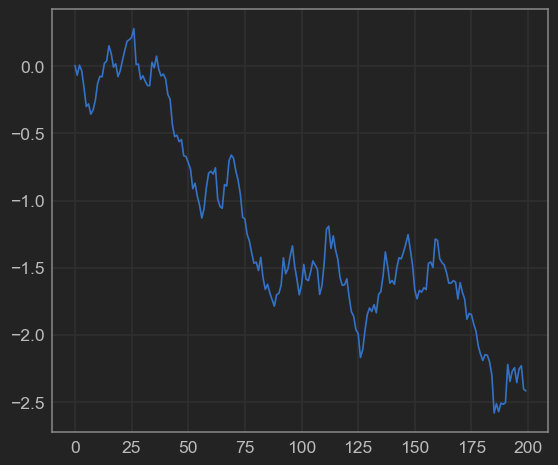

In [90]:
# generate a random walk
sd = .1
N = 200
deltas = np.random.normal(scale=sd, size=N)
y = np.cumsum(deltas)
x = np.arange(N)
fig, ax = plt.subplots()
ax.plot(x, y)

In [91]:
df = pd.DataFrame({'y': y})
df = df.reindex(np.arange(210))  # the unseen future

In [92]:
df

,y
0,0.004817
1,-0.067297
2,0.007217
3,-0.035276
4,-0.160201
...,...
205,NaN
206,NaN
207,NaN
208,NaN


In [95]:
pd.DataFrame(data={"vals":data})

,vals
2017-01-04,0.003038
2017-01-05,-0.002150
2017-01-06,0.003242
2017-01-09,-0.003828
2017-01-10,-0.001602
...,...
2021-03-10,NaN
2021-03-11,NaN
2021-03-12,NaN
2021-03-15,NaN


In [ ]:
# dji contains the observed data. Let's add some unobserved future days (fdays of them)
fdays = 50

# Compute new date index for new future trading days
last_trade_day = dji.index[-1]
next_trade_day = last_trade_day + dt.timedelta(days=1)
new_last_trade_day = last_trade_day + dt.timedelta(days=fdays)
nyse = mcal.get_calendar('NYSE')
new_mkt_days = nyse.valid_days(start_date=next_trade_day, end_date=new_last_trade_day).tz_localize(None)
while len(new_mkt_days) < fdays:
    new_last_trade_day += dt.timedelta(days=1)
    new_mkt_days = nyse.valid_days(start_date=next_trade_day, end_date=new_last_trade_day).tz_localize(None)
new_mkt_days = pd.Series(index=new_mkt_days)

# Make a new series with appended missing vals to be passed in
empty_vals = np.empty(fdays)
empty_vals[:] = np.nan
new_idx = dji.index.union(new_mkt_days.index)
data = pd.Series(index=new_idx, data=np.concatenate((dji.values, empty_vals)))
data = pd.DataFrame(data={"rets":data})